<a href="https://colab.research.google.com/github/GOODYSPEC/Goodness/blob/main/US_Company_Bankruptcy_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 📦 Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
data = pd.read_csv("/content/american_bankruptcy.csv")

In [ ]:
data = data.drop(columns=["Company", "Year", "Country"], errors='ignore')

In [ ]:
print(data.columns)

Index(['company_name', 'status_label', 'year', 'X1', 'X2', 'X3', 'X4', 'X5',
       'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16',
       'X17', 'X18'],
      dtype='object')


In [ ]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (0, 18)
y shape: (0,)


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['status_label'] = le.fit_transform(data['status_label'])

In [ ]:
y = data["status_label"]

In [ ]:
data = data.dropna(subset=["status_label"])


In [ ]:
X = data.drop(columns=["status_label", "year"], errors='ignore')
y = data["status_label"]


In [ ]:
print(X.shape, y.shape)


(78682, 19) (78682,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
print(X_train.select_dtypes(include='object').columns)


Index(['company_name'], dtype='object')


In [ ]:
print(X_train.select_dtypes(include='object').columns)

Index(['company_name'], dtype='object')


In [ ]:
X = data.drop(columns=["status_label", "year", "company_name"], errors='ignore')
y = data["status_label"]


In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)




In [ ]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [ ]:
models = {
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False)
}

In [ ]:
param_grid = {
    "DecisionTree": {
        "model__max_depth": [5, 10, 20],
        "model__min_samples_split": [2, 5]
    },
    "RandomForest": {
        "model__n_estimators": [50, 100],
        "model__max_depth": [5, 10],
        "model__min_samples_split": [2, 5]
    },
    "GradientBoosting": {
        "model__n_estimators": [50, 100],
        "model__max_depth": [3, 5],
        "model__learning_rate": [0.01, 0.1]
    },
    "KNN": {
        "model__n_neighbors": [3, 5, 7],
        "model__p": [1, 2]
    },
    "XGBoost": {
        "model__n_estimators": [50, 100],
        "model__max_depth": [3, 5],
        "model__learning_rate": [0.01, 0.1]
    }
}


In [ ]:
results = []
best_models = {}

for name in models:
    print(f"🔍 Tuning {name}...")
    pipeline = Pipeline([
        ("scaler", RobustScaler()),
        ("model", models[name])
    ])

    grid = GridSearchCV(pipeline, param_grid[name], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train_bal, y_train_bal)

    best_model = grid.best_estimator_
    best_models[name] = best_model  # ✅ fixed here

    # Predict on test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_prob)
    })


🔍 Tuning DecisionTree...
🔍 Tuning RandomForest...
🔍 Tuning GradientBoosting...
🔍 Tuning KNN...
🔍 Tuning XGBoost...


In [ ]:
results_df = pd.DataFrame(results).set_index("Model").round(3)
print("\n📊 Model Comparison Results:\n")
print(results_df)


📊 Model Comparison Results:

                  Accuracy  Precision  Recall  F1-Score  ROC AUC
Model                                                           
DecisionTree         0.814      0.177   0.496     0.261    0.673
RandomForest         0.737      0.147   0.616     0.237    0.758
GradientBoosting     0.732      0.147   0.634     0.239    0.755
KNN                  0.842      0.253   0.710     0.373    0.822
XGBoost              0.726      0.144   0.632     0.234    0.755


In [ ]:
import joblib
joblib.dump(best_models['KNN'], 'best_knn_model.pkl')


['best_knn_model.pkl']

In [ ]:
from sklearn.metrics import classification_report
y_pred = best_models['KNN'].predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91     14693
           1       0.25      0.71      0.37      1044

    accuracy                           0.84     15737
   macro avg       0.61      0.78      0.64     15737
weighted avg       0.93      0.84      0.87     15737



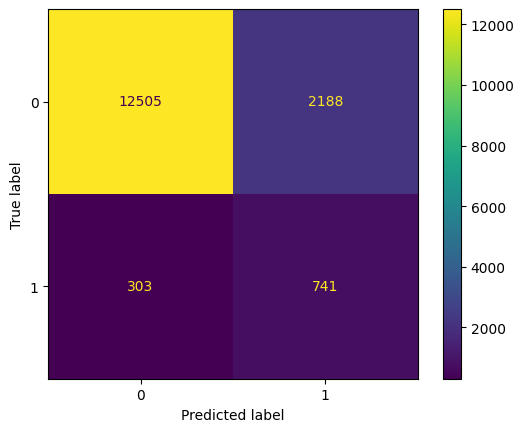

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_models['KNN'], X_test, y_test)


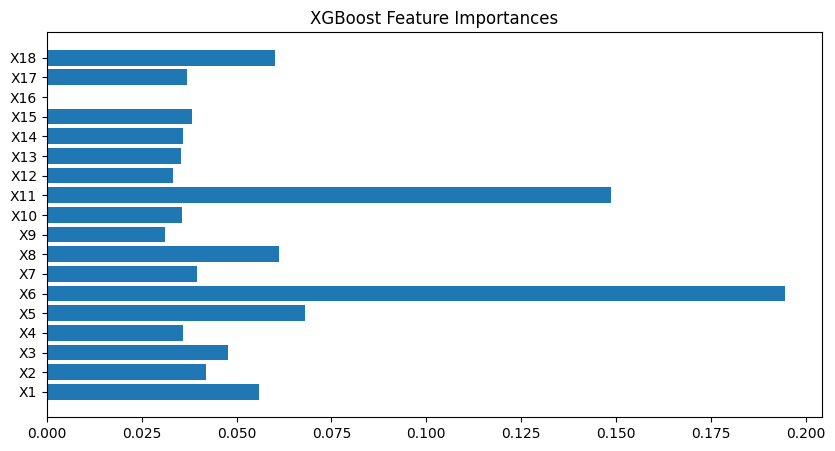

In [ ]:
import matplotlib.pyplot as plt

model = best_models['XGBoost'].named_steps['model']
importances = model.feature_importances_

plt.figure(figsize=(10, 5))
plt.barh(X.columns, importances)
plt.title("XGBoost Feature Importances")
plt.show()


In [1]:
from IPython.display import display, FileLink
display(FileLink("/content/US Bankruptcy Prediction Model Analysis.pdf"))


/content/US Bankruptcy Prediction Model Analysis.pdf